# Z3 SAT Constraints Encodings

In this notebook we are going to show several implementation in z3 of the cardinality constraints and show how they affect the efficiency of the solver. 

In [ ]:
!pip3 install z3-solver

In [ ]:
from itertools import combinations
from z3 import *
from utils import *
import math

## At most one encodings

### Naive pairwise

In [ ]:
def at_least_one_np(bool_vars):
    return Or(bool_vars)

def at_most_one_np(bool_vars, name = ""):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one_np(bool_vars, name = ""):
    return And(at_least_one_np(bool_vars), And(at_most_one_np(bool_vars, name)))

### Sequential 

In [ ]:
def at_least_one_seq(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_seq(bool_vars, name):
    constraints = []
    n = len(bool_vars)
    s = [Bool(f"s_{name}_{i}") for i in range(n - 1)]
    constraints.append(Or(Not(bool_vars[0]), s[0]))
    constraints.append(Or(Not(bool_vars[n-1]), Not(s[n-2])))
    for i in range(1, n - 1):
        constraints.append(Or(Not(bool_vars[i]), s[i]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i-1])))
        constraints.append(Or(Not(s[i-1]), s[i]))
    return And(constraints)

def exactly_one_seq(bool_vars, name):
    return And(at_least_one_seq(bool_vars), at_most_one_seq(bool_vars, name))

### Bitwise

In [ ]:
def toBinary(num, length = None):
    num_bin = bin(num).split("b")[-1]
    if length:
        return "0"*(length - len(num_bin)) + num_bin
    return num_bin
    
def at_least_one_bw(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_bw(bool_vars, name):
    constraints = []
    n = len(bool_vars)
    m = math.ceil(math.log2(n))
    r = [Bool(f"r_{name}_{i}") for i in range(m)]
    binaries = [toBinary(i, m) for i in range(n)]
    for i in range(n):
        for j in range(m):
            phi = Not(r[j])
            if binaries[i][j] == "1":
                phi = r[j]
            constraints.append(Or(Not(bool_vars[i]), phi))        
    return And(constraints)

def exactly_one_bw(bool_vars, name):
    return And(at_least_one_bw(bool_vars), at_most_one_bw(bool_vars, name)) 

### Heule 

In [ ]:
def at_least_one_he(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_he(bool_vars, name):
    if len(bool_vars) <= 4:
        return And(at_most_one_np(bool_vars))
    y = Bool(f"y_{name}")
    return And(And(at_most_one_np(bool_vars[:3] + [y])), And(at_most_one_he(bool_vars[3:] + [Not(y)], name+"_")))

def exactly_one_he(bool_vars, name):
    return And(at_most_one_he(bool_vars, name), at_least_one_he(bool_vars))

## Examples

### N-queens

In [283]:
def nqueens_sat(n):
    # Create all the variables
    p = [[Bool(f"x_{i}_{j}") for j in range(n)] for i in range(n)]

    # Create the solver instance
    s = Solver()

    # At least one on each row and column
    for i in range(n):
        s.add(at_least_one(p[i]))
        s.add(at_least_one([p[j][i] for j in range(n)]))

    # At most one on each row and column
    for i in range(n):
        col_i = []
        for j in range(n):
            col_i += [p[j][i]]
        s.add(at_most_one(p[i], f"row_{i}"))
        s.add(at_most_one(col_i, f"col_{i}"))

    # Add the diagonal constraints
    for i in range(n - 1):
        diag_ru = []
        diag_lu = []
        diag_rl = []
        diag_ll = []
        for j in range(n - i):
            diag_ru += [p[i + j][j]]
            diag_lu += [p[n - 1 - (i + j)][j]]
            diag_rl += [p[i + j][n - 1 - j]]
            diag_ll += [p[n - 1 - (i + j)][n - 1 - j]]
        s.add(at_most_one(diag_ru, f"diag_ru_{i}"))
        s.add(at_most_one(diag_lu, f"diag_lu_{i}"))
        s.add(at_most_one(diag_rl, f"diag_rl_{i}"))
        s.add(at_most_one(diag_ll, f"diag_ll_{i}"))

    s.check()

    m = s.model()
    return [(i, j) for i in range(n) for j in range(n) if m.evaluate(p[i][j])]

In [335]:
%%time
at_most_one = at_most_one_np
at_least_one = at_least_one_np 
exactly_one = exactly_one_np
display_nqueens(nqueens_sat(32))

. . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . 
. . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . 
. . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . 
. . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . 
. . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ 
. . . . . . . . . . . . .

In [336]:
%%time
at_most_one = at_most_one_seq
at_least_one = at_least_one_seq
exactly_one = exactly_one_seq
display_nqueens(nqueens_sat(32))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ 
. . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . 
. . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . 
. . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . 
. . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . 
. ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . 
. . . . . . . . ♛ . . . .

In [337]:
%%time
at_most_one = at_most_one_bw
at_least_one = at_least_one_bw
exactly_one = exactly_one_bw
display_nqueens(nqueens_sat(32))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . 
. ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ 
. . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . 
. . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . 
. . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . 
. . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . 
. . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . 
. . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . 
. . ♛ . . . . . . . . . .

In [348]:
%%time
at_most_one = at_most_one_he
at_least_one = at_least_one_he
exactly_one = exactly_one_he
display_nqueens(nqueens_sat(32))

. . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . 
. . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . 
. . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ 
. . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . 
. ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . 
. . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . 
. . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . .

### sudoku

In [367]:
# Sudoku instances, '0's correspond to empty cells

instance1 = ((0, 0, 0, 0, 9, 4, 0, 3, 0),
             (0, 0, 0, 5, 1, 0, 0, 0, 7),
             (0, 8, 9, 0, 0, 0, 0, 4, 0),
             (0, 0, 0, 0, 0, 0, 2, 0, 8),
             (0, 6, 0, 2, 0, 1, 0, 5, 0),
             (1, 0, 2, 0, 0, 0, 0, 0, 0),
             (0, 7, 0, 0, 0, 0, 5, 2, 0),
             (9, 0, 0, 0, 6, 5, 0, 0, 0),
             (0, 4, 0, 9, 7, 0, 0, 0, 0))

instance2 = ((0, 0, 0, 0, 9, 0, 1, 0, 0),
             (2, 8, 0, 0, 0, 5, 0, 0, 0),
             (7, 0, 0, 0, 0, 6, 4, 0, 0),
             (8, 0, 5, 0, 0, 3, 0, 0, 6),
             (0, 0, 1, 0, 0, 4, 0, 0, 0),
             (0, 7, 0, 2, 0, 0, 0, 0, 0),
             (3, 0, 0, 0, 0, 1, 0, 8, 0),
             (0, 0, 0, 0, 0, 0, 0, 5, 0),
             (0, 9, 0, 0, 0, 0, 0, 7, 0))

instance3 = ((0, 7, 0, 0, 0, 0, 0, 4, 9),
             (0, 0, 0, 4, 0, 0, 0, 0, 0),
             (4, 0, 3, 5, 0, 7, 0, 0, 8),
             (0, 0, 7, 2, 5, 0, 4, 0, 0),
             (0, 0, 0, 0, 0, 0, 8, 0, 0),
             (0, 0, 4, 0, 3, 0, 5, 9, 2),
             (6, 1, 8, 0, 0, 0, 0, 0, 5),
             (0, 9, 0, 1, 0, 0, 0, 3, 0),
             (0, 0, 5, 0, 0, 0, 0, 0, 7))

instance4 = ((0, 0, 0, 0, 0, 6, 0, 0, 0),
             (0, 5, 9, 0, 0, 0, 0, 0, 8),
             (2, 0, 0, 0, 0, 8, 0, 0, 0),
             (0, 4, 5, 0, 0, 0, 0, 0, 0),
             (0, 0, 3, 0, 0, 0, 0, 0, 0),
             (0, 0, 6, 0, 0, 3, 0, 5, 4),
             (0, 0, 0, 3, 2, 5, 0, 0, 6),
             (0, 0, 0, 0, 0, 0, 0, 0, 0),
             (0, 0, 0, 0, 0, 0, 0, 0, 0))

In [368]:
def sudoku_sat(instance):
    # All the variables we need: for each cell, nine variables that determine which digit must be assigned.
    v = [[[Bool(f"v_{i}_{j}_{k}") for k in range(9)] for j in range(9)] for i in range(9)]

    s = Solver()

    # A cell has only one value
    for i in range(9):
        for j in range(9):
            s.add(exactly_one(v[i][j], f"valid_cell_{i}_{j}"))

    # Each value is used only once in a row
    for j in range(9):
        for k in range(9):
            s.add(exactly_one([v[i][j][k] for i in range(9)], f"valid_row_{j}_{k}"))

    # Each value used exactly once in each column
    for i in range(9):
        for k in range(9):
            s.add(exactly_one([v[i][j][k] for j in range(9)], f"valid_column_{i}_{k}"))

    # Each value used exactly once in each 3x3 grid.
    for ii in range(3):
        for jj in range(3):
            for k in range(9):
                grid_cells = [v[3 * ii + a][3 * jj + b][k] for a in range(3) for b in range(3)]
                s.add(exactly_one(grid_cells, f"valid_grid_{ii}_{jj}_{k}"))

    # Some numbers are already available
    for i in range(9):
        for j in range(9):
            if instance[i][j] > 0:
                s.add(v[i][j][instance[i][j] - 1])

    if s.check() == sat:
        m = s.model()
        sol = []
        for i in range(9):
            sol.append([])
            for j in range(9):
                for k in range(9):
                    if m.evaluate(v[i][j][k]):
                        sol[i].append(k+1)
        return sol
    else:
        print("Failed to solve")

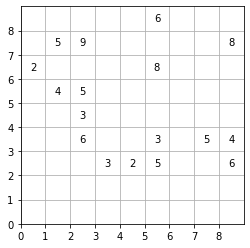

In [369]:
# Select the instance you want to solve
instance = instance4
display_sudoku(instance)

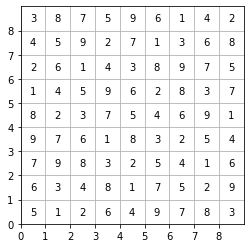

CPU times: user 3.01 s, sys: 54.1 ms, total: 3.07 s
Wall time: 3.21 s


In [370]:
%%time
at_most_one = at_most_one_np
at_least_one = at_least_one_np 
exactly_one = exactly_one_np
display_sudoku(sudoku_sat(instance))

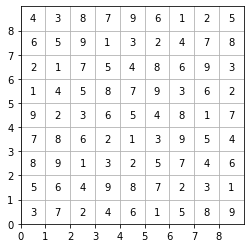

CPU times: user 2.52 s, sys: 66.8 ms, total: 2.59 s
Wall time: 2.74 s


In [371]:
%%time
at_most_one = at_most_one_seq
at_least_one = at_least_one_seq 
exactly_one = exactly_one_seq
display_sudoku(sudoku_sat(instance))

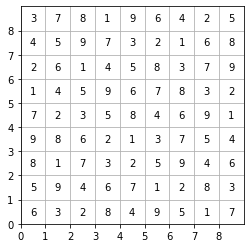

CPU times: user 3.93 s, sys: 99.5 ms, total: 4.03 s
Wall time: 4.35 s


In [372]:
%%time
at_most_one = at_most_one_bw
at_least_one = at_least_one_bw
exactly_one = exactly_one_bw
display_sudoku(sudoku_sat(instance))

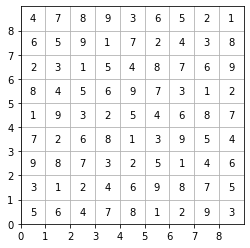

CPU times: user 2.39 s, sys: 62.6 ms, total: 2.46 s
Wall time: 2.47 s


In [373]:
%%time
at_most_one = at_most_one_he
at_least_one = at_least_one_he
exactly_one = exactly_one_he
display_sudoku(sudoku_sat(instance))

## At most k encodings

### Naive pairwise

In [ ]:
def at_least_k_np(bool_vars, k, name = ""):
    return at_most_k_np([Not(var) for var in bool_vars], len(bool_vars)-k, name)

def at_most_k_np(bool_vars, k, name = ""):
    return And([Or([Not(x) for x in X]) for X in combinations(bool_vars, k + 1)])

def exactly_k_np(bool_vars, k, name = ""):
    return And(at_most_k_np(bool_vars, k, name), at_least_k_np(bool_vars, k, name))

### Sequential

In [ ]:
def at_least_k_seq(bool_vars, k, name):
    return at_most_k_seq([Not(var) for var in bool_vars], len(bool_vars)-k, name)

def at_most_k_seq(bool_vars, k, name):
    constraints = []
    n = len(bool_vars)
    s = [[Bool(f"s_{name}_{i}_{j}") for j in range(k)] for i in range(n - 1)]
    constraints.append(Or(Not(bool_vars[0]), s[0][0]))
    constraints += [Not(s[0][j]) for j in range(1, k)]
    for i in range(1, n-1):
        constraints.append(Or(Not(bool_vars[i]), s[i][0]))
        constraints.append(Or(Not(s[i-1][0]), s[i][0]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i-1][k-1])))
        for j in range(1, k):
            constraints.append(Or(Not(bool_vars[i]), Not(s[i-1][j-1]), s[i][j]))
            constraints.append(Or(Not(s[i-1][j]), s[i][j]))
    constraints.append(Or(Not(bool_vars[n-1]), Not(s[n-2][k-1])))   
    return And(constraints)

def exactly_k_seq(bool_vars, k, name):
    return And(at_most_k_seq(bool_vars, k, name), at_least_k_seq(bool_vars, k, name))

## Examples

### Nurse scheduling problem

In [ ]:
instance1 = {
    "num_nurses" : 4,
    "num_shifts" : 3,
    "num_days" : 3
}

instance2 = {
    "num_nurses" : 4,
    "num_shifts" : 3,
    "num_days" : 4
}

instance3 = {
    "num_nurses" : 10,
    "num_shifts" : 3,
    "num_days" : 30
}

In [ ]:
def nurse_scheduling_sat(num_nurses, num_shifts, num_days):
    # Create all the variables, shifts[i, j, k] is True if shift k is assigned to nurse i on day j.
    shifts = [[[Bool(f"x_{i}_{j}_{k}") for k in range(num_shifts)] for j in range(num_days)] for i in range(num_nurses)]

    s = Solver()
    
    # In each shift can work just one nurse 
    for j in range(num_days):
        for k in range(num_shifts):
            s.add(exactly_one([shifts[i][j][k] for i in range(num_nurses)],  f"one_nurse_{j}_{k}"))
    
    # Each nurse can work one shift per day
    for i in range(num_nurses):
        for j in range(num_days):
            s.add(at_most_one(shifts[i][j], f"one_shift_{i}_{j}"))
            
    # Fair assignment of shifts
    min_shifts_per_nurse = (num_shifts * num_days) // num_nurses
    if num_shifts * num_days % num_nurses == 0:
        max_shifts_per_nurse = min_shifts_per_nurse
    else:
        max_shifts_per_nurse = min_shifts_per_nurse + 1
    for i in range(num_nurses):
        shifts_worked = []
        for j in range(num_days):
            for k in range(num_shifts):
                shifts_worked.append(shifts[i][j][k])
        s.add(at_least_k(shifts_worked, min_shifts_per_nurse, f"shifts_worked_min_{i}"))
        s.add(at_most_k(shifts_worked, max_shifts_per_nurse, f"shifts_worked_max_{i}"))
    
    s.check()
    
    if s.check() == sat:
        m = s.model()
        return [(i, j, k) for i in range(num_nurses) for j in range(num_days) for k in range(num_shifts) if m.evaluate(shifts[i][j][k])]
    else:
        return "Unsat"     

In [ ]:
instance = instance2
exactly_one = exactly_one_seq
at_most_one = at_most_one_seq

In [ ]:
%%time
at_most_k = at_most_k_np
at_least_k = at_least_k_np
exactly_k = exactly_k_np
display_nurses_shifts(nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"]), instance["num_nurses"], instance["num_shifts"], instance["num_days"])

In [475]:
%%time
at_most_k = at_most_k_seq
at_least_k = at_least_k_seq
exactly_k = exactly_k_seq
display_nurses_shifts(nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"]), instance["num_nurses"], instance["num_shifts"], instance["num_days"])

sat
Day 0
  Nurse 0 does not work
  Nurse 1 does not work
  Nurse 2 works shift 0
  Nurse 3 does not work
  Nurse 4 works shift 2
  Nurse 5 does not work
  Nurse 6 works shift 1
  Nurse 7 does not work
  Nurse 8 does not work
  Nurse 9 does not work
Day 1
  Nurse 0 works shift 2
  Nurse 1 works shift 0
  Nurse 2 does not work
  Nurse 3 does not work
  Nurse 4 works shift 1
  Nurse 5 does not work
  Nurse 6 does not work
  Nurse 7 does not work
  Nurse 8 does not work
  Nurse 9 does not work
Day 2
  Nurse 0 does not work
  Nurse 1 works shift 1
  Nurse 2 does not work
  Nurse 3 does not work
  Nurse 4 does not work
  Nurse 5 works shift 2
  Nurse 6 does not work
  Nurse 7 works shift 0
  Nurse 8 does not work
  Nurse 9 does not work
Day 3
  Nurse 0 works shift 1
  Nurse 1 works shift 0
  Nurse 2 does not work
  Nurse 3 does not work
  Nurse 4 does not work
  Nurse 5 does not work
  Nurse 6 works shift 2
  Nurse 7 does not work
  Nurse 8 does not work
  Nurse 9 does not work
Day 4
  Nurs